In [66]:
import pandas as pd
import os
import requests
from geopy.distance import geodesic

from dotenv import load_dotenv
load_dotenv()

True

In [67]:
google_api_key = os.getenv("GOOGLE_API_KEY")

In [ ]:
df = pd.read_csv('geotags_processed.csv')

In [5]:
df_cat_2 = df[df['categorie'] == '2']
df_cat_2.shape

(320, 4)

In [39]:
df_original = pd.read_csv('urgent_interventions_formatted.csv')
df_original.shape

(2888, 27)

In [37]:
df_cat_2_merged = pd.merge(df_cat_2, df_original, on='id', how='inner')
df_cat_2_merged.shape

(320, 30)

In [47]:
remove_rows = [129150, 130109, 133933, 135465, 107603, 121857, 122907, 124337, 126555, 128697, 128836, 132610, 133353, 133372, 108578, 109228, 110662, 111325, 111552, 112567, 112753, 113401, 114029, 114915, 117012, 118989, 120091, 120300, 120535, 120583, 121866, 122153, 128190, 116756]

In [48]:
df_cat_2_merged = df_cat_2_merged[~df_cat_2_merged['id'].isin(remove_rows)]
df_cat_2_merged.shape

(286, 30)

In [54]:
df_cat_2_merged.to_csv('df_cat_2_ready.csv', index=False)

In [51]:
df_cat_2_merged[~df_cat_2_merged['latitude_corr'].isnull()].shape

(14, 30)

In [49]:
all_urgent_interventions = pd.read_csv('urgent_interventions_formatted.csv')
all_urgent_interventions.shape

(2888, 27)

In [50]:
add_rows = [135420, 125642, 126628, 127020, 129292, 130776, 108447, 108663, 109155, 110384, 111491, 112558, 114088, 114280, 114990, 116753, 131566, 138572, 126616, 126922, 107557, 109629, 112490, 112775, 113791, 114098, 114479, 114764, 117115]

In [52]:
df_cat_2_merged = pd.concat([df_cat_2_merged, all_urgent_interventions[all_urgent_interventions['id'].isin(add_rows) & ~all_urgent_interventions['id'].isin(df_cat_2_merged['id'])]])
df_cat_2_merged.shape

(305, 30)

In [53]:
df_cat_2_merged[~df_cat_2_merged['latitude_corr'].isnull()].shape

(33, 30)

In [38]:
df_cat_2_merged[~df_cat_2_merged['latitude_corr'].isnull()].shape

(16, 30)

In [ ]:
df_cat_2_merged.to_csv('df_cat_2_ready.csv', index=False)

# Uitvoering

In [ ]:
df_cat_2_merged = pd.read_csv('df_cat_2_ready.csv')

In [57]:
df_cat_2_merged['is_wrong_true'] = df_cat_2_merged['latitude_corr'].apply(lambda x: 1 if pd.notnull(x) else 0)
df_cat_2_merged['is_wrong_true'].value_counts()

is_wrong_true
0    272
1     33
Name: count, dtype: int64

In [72]:
url = 'https://places.googleapis.com/v1/places:searchText'
headers = {
    'Content-Type': 'application/json',
    'X-Goog-Api-Key': google_api_key,
    'X-Goog-FieldMask': 'places.displayName,places.formattedAddress,places.location'
}

def post_req(geo_tag, street='', number='', city='Turnhout'):
    data = {
        "textQuery": '{} {} {} {}'.format(geo_tag, street, number, city, 'België')
    }
    return requests.post(url, headers=headers, json=data)

In [73]:
def calc_distance(coord1, coord2):
    return geodesic(coord1, coord2).kilometers

In [ ]:
for i, row in df_cat_2_merged.iterrows():
    try:
        geotag = row['geotag']
        street = row['Street']
        number = row['Number']
        city = row['City']
        
        response = post_req(geotag, street, number, city)
        response_json = response.json()
        if 'places' not in response_json or not response_json['places']:
            continue
        
        min_distance = float('inf')
        min_coords = None
        
        for place in response_json['places']:
            place_coord = (place['location']['latitude'], place['location']['longitude'])
            distance = calc_distance((row['latitude'], row['longitude']), place_coord)
            if distance < min_distance:
                min_distance = distance
                min_coords = place_coord
        
        threshold = 0.1
        
        if min_distance < threshold:
            df_cat_2_merged.loc[i, 'is_wrong_pred'] = 0
        else:
            df_cat_2_merged.loc[i, 'is_wrong_pred'] = 1
          
        df_cat_2_merged.loc[i, 'latitude_pred'] = min_coords[0]
        df_cat_2_merged.loc[i, 'longitude_pred'] = min_coords[1]
        df_cat_2_merged.loc[i, 'distance_pred'] = min_distance

    except Exception as e:
        print(f'Error {e} at index {i}')
        continue

In [88]:
df_cat_2_merged.to_csv('df_cat_2_results.csv', index=False)

In [89]:
df_cat_2_merged['is_wrong_pred'].value_counts()

is_wrong_pred
0.0    173
1.0    114
Name: count, dtype: int64

In [90]:
df_cat_2_merged['distance_pred'].describe()

count    287.000000
mean       0.834747
std        8.386243
min        0.002549
25%        0.022593
50%        0.061399
75%        0.245213
max      141.810974
Name: distance_pred, dtype: float64

In [92]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [94]:
df_cat_2_merged['is_wrong_pred'] = df_cat_2_merged['is_wrong_pred'].fillna(0)

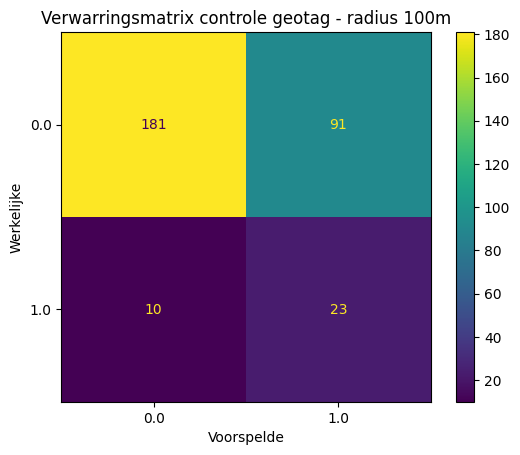

In [98]:
unique_labels = sorted(df_cat_2_merged['is_wrong_pred'].unique())
ConfusionMatrixDisplay.from_predictions(df_cat_2_merged['is_wrong_true'], df_cat_2_merged['is_wrong_pred'], labels=unique_labels)
plt.title('Verwarringsmatrix controle geotag - radius 100m')
plt.xlabel('Voorspelde')
plt.ylabel('Werkelijke')
plt.show()

In [99]:
# new column is_wrong_pred_150m, 0 if distance_pred < 0.15, 1 otherwise
df_cat_2_merged['is_wrong_pred_50m'] = df_cat_2_merged['distance_pred'].apply(lambda x: 1 if x >= 0.05 else 0)
df_cat_2_merged['is_wrong_pred_150m'] = df_cat_2_merged['distance_pred'].apply(lambda x: 1 if x >= 0.15 else 0)

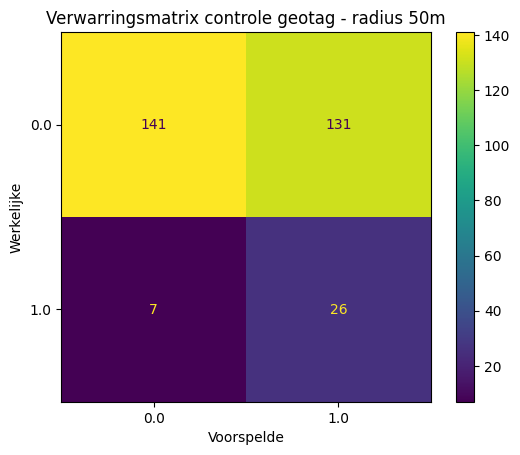

In [103]:
ConfusionMatrixDisplay.from_predictions(df_cat_2_merged['is_wrong_true'], df_cat_2_merged['is_wrong_pred_50m'], labels=unique_labels)
plt.title('Verwarringsmatrix controle geotag - radius 50m')
plt.xlabel('Voorspelde')
plt.ylabel('Werkelijke')
plt.show()

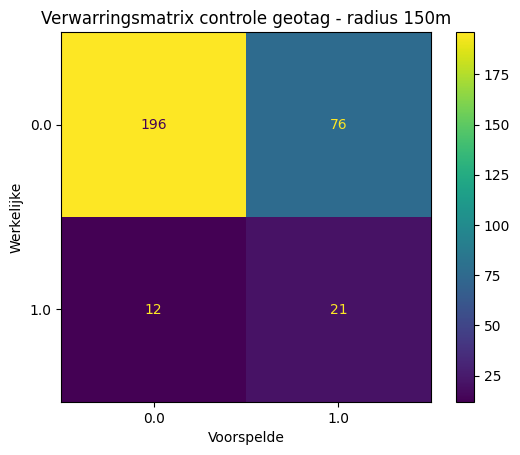

In [104]:
ConfusionMatrixDisplay.from_predictions(df_cat_2_merged['is_wrong_true'], df_cat_2_merged['is_wrong_pred_150m'], labels=unique_labels)
plt.title('Verwarringsmatrix controle geotag - radius 150m')
plt.xlabel('Voorspelde')
plt.ylabel('Werkelijke')
plt.show()

In [102]:
df_cat_2_merged['is_wrong_pred_200m'] = df_cat_2_merged['distance_pred'].apply(lambda x: 1 if x >= 0.2 else 0)

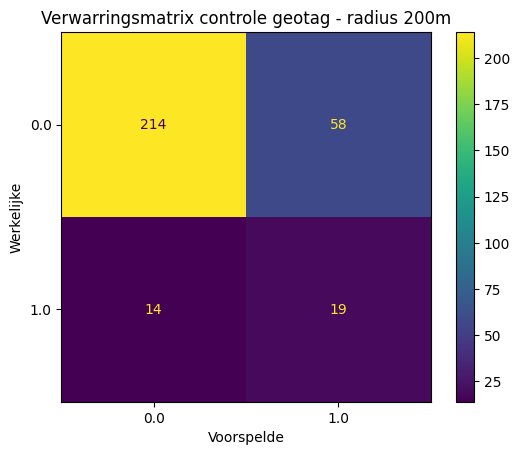

In [105]:
ConfusionMatrixDisplay.from_predictions(df_cat_2_merged['is_wrong_true'], df_cat_2_merged['is_wrong_pred_200m'], labels=unique_labels)
plt.title('Verwarringsmatrix controle geotag - radius 200m')
plt.xlabel('Voorspelde')
plt.ylabel('Werkelijke')
plt.show()